# ABU量化系统使用文档 

<center>
        <img src="./image/abu_logo.png" alt="" style="vertical-align:middle;padding:10px 20px;"><font size="6" color="black"><b>第15节 量化交易和搜索引擎</b></font>
</center>

-----------------

作者: 阿布

阿布量化版权所有 未经允许 禁止转载

[abu量化系统github地址](https://github.com/bbfamily/abu) (欢迎+star)

[本节ipython notebook](https://github.com/bbfamily/abu/tree/master/abupy_lecture)

>骰子? 骰子是什么东西?它应该出现在大富翁游戏里,应该出现在澳门和拉斯维加斯的赌场中，但是，物理学？不，那不是它应该来的地方。骰子代表了投机，代表了不确定，而物理学不是一门最严格最精密，最不能容忍不确定的科学吗？——《量子物理史话》

虽然我们无法对市场做到确定性的预测，但是股票市场也并不是杂乱无章的，预测和混沌之前存在着一种状态，这种状态可以使用使用概率来描述。《量子物理史话》中薛定谔方程说整个宇宙，你和我都是概率，波恩对波动方程的解释为：电子电荷在空间中的实际分布是电子在某处出现的概率，我们只能预言概率！电子有90%的可能出现在这里, 10%的可能出现在那里，我们也同然可以使用统计来预言概率，如某个策略在某种情况下失败概率为90%，成功概率为10%。

本节将介绍abu量化系统中的ump模块，它使用了多种机器学习技术，来实现我上面说的预测概率, 首先导入abupy中本节使用的模块：

In [1]:
# 基础库导入

from __future__ import print_function
from __future__ import division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
# 使用insert 0即只使用github，避免交叉使用了pip安装的abupy，导致的版本不一致问题
sys.path.insert(0, os.path.abspath('../'))
import abupy

# 使用沙盒数据，目的是和书中一样的数据环境
abupy.env.enable_example_env_ipython()

enable example env will only read RomDataBu/df_kl.h5


In [22]:
from abupy import AbuFactorAtrNStop, AbuFactorPreAtrNStop, AbuFactorCloseAtrNStop, AbuFactorBuyBreak, ABuProgress
from abupy import abu, EMarketTargetType, AbuMetricsBase, ABuMarketDrawing, AbuFuturesCn, ABuSymbolPd, ABuMarket
from abupy import AbuUmpMainDeg, AbuUmpMainJump, AbuUmpMainPrice, AbuUmpMainWave, AbuFuturesCn, EStoreAbu

受限于沙盒中数据限制，本节示例的相关性分析只限制在abupy内置沙盒数据中，完整示例以及代码请阅读后面章节的全市场回测示例或者《量化交易之路》中相关章节。

首先将内置沙盒中美股，A股，港股, 比特币，莱特币，期货市场中的symbol都列出来:

In [23]:
us_choice_symbols = ['usTSLA', 'usNOAH', 'usSFUN', 'usBIDU', 'usAAPL', 'usGOOG', 'usWUBA', 'usVIPS']
cn_choice_symbols = ['002230', '300104', '300059', '601766', '600085', '600036', '600809', '000002', '002594']
hk_choice_symbols = ['hk03333', 'hk00700', 'hk02333', 'hk01359', 'hk00656', 'hk03888', 'hk02318']
tc_choice_symbols = ['btc', 'ltc']
# 期货市场的直接从AbuFuturesCn().symbo中读取
ft_choice_symbols = AbuFuturesCn().symbol.tolist()

### 1. 切分训练集交易的回测

下面把沙盒数据中的symbol分成两组，一组做为训练symbol

* 本例训练集symbol使用：沙盒中所有美股 ＋ 沙盒中所有A股 ＋ 沙盒中所有港股 ＋ 比特币
* 本例测试集symbol使用：沙盒中所有期货 ＋ 莱特币

备注：本例由于symbol数量少所以手动分配训练集，测试集，非沙盒数据环境下使用abupy.env.g_enable_train_test_split等相关设置进行对参数中的symbol或者某个全市场symbol进行自动切割训练集，测试集，详例请阅读《量化交易之路》中相关章节

In [24]:
# 训练集：沙盒中所有美股 ＋ 沙盒中所有A股 ＋ 沙盒中所有港股 ＋ 比特币
train_choice_symbols = us_choice_symbols + cn_choice_symbols +  hk_choice_symbols + tc_choice_symbols[:1]
# 测试集：沙盒中所有期货 ＋ 莱特币
test_choice_symbols = ft_choice_symbols  + tc_choice_symbols[1:]

下面的买入因子，卖出因子继续使用之前章节的设置，如下所示：

In [25]:
# 设置初始资金数
read_cash = 1000000
# 买入因子依然延用向上突破因子
buy_factors = [{'xd': 60, 'class': AbuFactorBuyBreak},
               {'xd': 42, 'class': AbuFactorBuyBreak}]

# 卖出因子继续使用上一节使用的因子
sell_factors = [
    {'stop_loss_n': 1.0, 'stop_win_n': 3.0,
     'class': AbuFactorAtrNStop},
    {'class': AbuFactorPreAtrNStop, 'pre_atr_n': 1.5},
    {'class': AbuFactorCloseAtrNStop, 'close_atr_n': 1.5}
]

本节示例的裁判系统是建立在机器学习技术基础上的，所以必然会涉及到特征，abu量化系统支持在回测过程中生成特征数据，切分训练测试集，甚至成交买单快照图片，通过下面的一行代码设置即可在生成最终的输出结果数据orders_pd上加上买入时刻的很多信息，比如价格位置、趋势走向、波动情况等等特征：

* 关于特征的类的具体编写请阅读源代码ABuMLFeature以及ABuKLManager
* 本节只示例使用内置特征，在之后的章节后示例自定义特征类的实现

In [26]:
# 回测生成买入时刻特征
abupy.env.g_enable_ml_feature = True

下面通过abu.run_loop_back进行回测，choice_symbol使用分配好的训练集symbol：

In [7]:
abu_result_tuple_train, _ = abu.run_loop_back(read_cash,
                                                   buy_factors,
                                                   sell_factors,
                                                   start='2014-07-26',
                                                   end='2016-07-26',
                                                   choice_symbols=train_choice_symbols)
ABuProgress.clear_output()
# 把运行的结果保存在本地，以便后面的章节直接使用，保存回测结果数据代码如下所示
abu.store_abu_result_tuple(abu_result_tuple_train, n_folds=2, store_type=EStoreAbu.E_STORE_CUSTOM_NAME,
                           custom_name='lecture_train')
orders_pd_train = abu_result_tuple_train.orders_pd

please wait! dump_pickle....: /Users/Bailey/abu/data/cache/n2_lecture_train_capital
please wait! dump_pickle....: /Users/Bailey/abu/data/cache/n2_lecture_train_benchmark


回测结束后，看一些orders_pd的columns，可以看到buy_deg_ang252，buy_price_rank90，buy_atr_std，buy_wave_score3等等都是特征列：

In [8]:
orders_pd_train.columns

Index(['buy_date', 'buy_price', 'buy_cnt', 'buy_factor', 'symbol', 'buy_pos',
       'buy_type_str', 'expect_direction', 'sell_type_extra', 'sell_date',
       'sell_price', 'sell_type', 'ml_features', 'key', 'profit', 'result',
       'buy_deg_ang42', 'buy_deg_ang252', 'buy_deg_ang60', 'buy_deg_ang21',
       'buy_price_rank120', 'buy_price_rank90', 'buy_price_rank60',
       'buy_price_rank252', 'buy_wave_score1', 'buy_wave_score2',
       'buy_wave_score3', 'buy_atr_std', 'buy_jump_down_power',
       'buy_jump_up_power', 'buy_diff_down_days', 'buy_diff_up_days',
       'sell_deg_ang42', 'sell_deg_ang252', 'sell_deg_ang60', 'sell_deg_ang21',
       'sell_price_rank120', 'sell_price_rank90', 'sell_price_rank60',
       'sell_price_rank252', 'sell_wave_score1', 'sell_wave_score2',
       'sell_wave_score3', 'sell_jump_down_power', 'sell_jump_up_power',
       'sell_diff_down_days', 'sell_diff_up_days'],
      dtype='object')

下面看看生成的特征的具体示例，如下所示：

备注：buy开头的是买入时刻形成的特征，sell开头的是卖出时刻形成的特征

In [9]:
orders_pd_train.filter(regex='buy*').drop(
    ['buy_date', 'buy_price', 'buy_cnt', 'buy_factor', 'buy_pos', 'buy_type_str'], axis=1).head()

,buy_deg_ang42,buy_deg_ang252,buy_deg_ang60,buy_deg_ang21,buy_price_rank120,buy_price_rank90,buy_price_rank60,buy_price_rank252,buy_wave_score1,buy_wave_score2,buy_wave_score3,buy_atr_std,buy_jump_down_power,buy_jump_up_power,buy_diff_down_days,buy_diff_up_days
2014-09-25,7.168,-3.708,4.342,2.255,1.000,1.000,1.000,0.857,0.496,0.454,0.441,1.159,-1.369,0.000,77,0
2014-10-09,-0.567,-6.527,1.309,1.837,0.992,0.989,0.983,0.798,0.230,0.072,-0.001,1.281,0.000,0.000,0,0
2014-10-17,2.328,4.764,2.096,2.357,1.000,1.000,1.000,1.000,0.743,0.374,0.232,2.033,0.000,1.778,0,41
2014-10-24,-0.454,5.532,2.142,0.931,1.000,1.000,1.000,1.000,1.251,1.290,1.289,0.192,-13.570,1.038,136,2
2014-10-24,-0.454,5.532,2.142,0.931,1.000,1.000,1.000,1.000,1.251,1.290,1.289,0.192,-13.570,1.038,136,2


下面度量训练集使用returns_cmp模式，即不对比标尺大盘，在无资金限制下所有买入交易都可以成交的模式, 如下所示：

In [10]:
AbuMetricsBase.show_general(*abu_result_tuple_train, returns_cmp=True, only_info=True)

买入后卖出的交易数量:196
买入后尚未卖出的交易数量:9
胜率:59.6939%
平均获利期望:18.6899%
平均亏损期望:-7.1235%
盈亏比:4.4972
所有交易收益比例和:16.2396 
所有交易总盈亏和:2717948.4900 


如上所示的输出即为无资金限制所有买入交易都可以成交的模式下的度量结果，可以看到：所有交易总盈亏和:2717948，但实际上如果在考虑资金的情况下的实际交易总盈亏和并没有这么多，因为有很多交易因为资金限制没能买入成交，如下所示：

In [11]:
capital_pd = abu_result_tuple_train.capital.capital_pd
capital_pd['capital_blance'][-1] - capital_pd['capital_blance'][0]

1364434.764

本节的示例回测的度量都将使用无资金限制下所有买入交易都可以成交的模式。

备注：无资金限制下所有买入交易都可以成交的模式具体实现请阅读AbuMetricsBase

进入本节核心主体量化交易和搜索引擎结果的好坏最相似的地方有两个：

1. 对搜索引擎（量化策略）失败结果的人工分析，注重分析失败的结果以及是否存在改进方案，改进方案是否会引进新的问题
2. 机器学习技术在搜索引擎（量化策略）上的改进，必须赋予宏观上合理的解释

下面将依次展开以上两点：

### 2. 对交易进行人工分析

对交易进行人工分析最常用的手动即是直接可视化交易的买入卖出点及走势。

下面使用plot_candle_from_order直接将orders_pd(交易单子数据)作为参数传入，save=True将交易当时买入点、卖出点等信息标注在图上并保存在本地，针对保存后的交易快照我们就可以进行人工分析：

In [12]:
# 选择失败的笔交易绘制交易快照
plot_simple = orders_pd_train[orders_pd_train.profit_cg < 0]
# save=True保存在本地，耗时操作，需要运行几分钟
ABuMarketDrawing.plot_candle_from_order(plot_simple, save=True)

保存完成后，快照将保存在~/abu/data/save_png下当前日期的文件夹中，可使用如下命令直接打开查看：

In [13]:
if abupy.env.g_is_mac_os:
    !open $abupy.env.g_project_data_dir
else:
    !echo $abupy.env.g_project_data_dir

通过人工分析这些失败的交易，可以观察是否有改进方案，或者不合理的交易，比如下面这笔交易：

![](./image/ump_trade.png)

从上面趋势图可以看出：之前大幅度下跌后，底部开始向上拉升，可以发现买入点是在前期阻力位的位置，你可以在具体策略中编写代码阻止类似的交易生效，但是这样容易过拟合，并且这种对策略的微调一定也会带来一些负面的影响，很难量化最终的得失。

而且这样会导致你的基础策略太过复杂，基础追求的就应该是简单, **可以一句话说明你的基础策略**，针对此类问题的一种解决方法在之前的第九节港股市场的回测中将优化策略的'策略'做为类装饰器进行封装有做过示例讲解，具体效果即是分离基础策略和策略优化监督模块，提高灵活度和适配性，本节示例通过ump来解决此类问题。


abupy中ump模块的设计目标是：

1. 不需要在具体策略中硬编码
2. 不需要人工设定阀值，即且使得代码逻辑清晰
3. 分离基础策略和策略优化监督模块，提高灵活度和适配性
4. 发现策略中隐藏的交易策略问题
5. 可以通过不断的学习新的交易数据

现阶段的量化策略还是通过人来编写代码，未来的发展也许会向着完全由计算机实现整套流程的方向迈进，包括量化策略本身。

abupy的设计目标是：

只需要提供一些基础的简单种子策略代码，计算机在这些简单种子策略基础上不断自我学习、自我完善，创造新的策略，并且紧跟时间序列不断自我调整策略参数。

### 3. 主裁系统原理:

下面的内容主要示例通过abupy中的ump模块解决上述问题，abu量化系统中的ump裁判模块，abu量化系统命名规则里，a代表alpha，b代表beta，u代表ump即裁判员的意思，ump将策略回测交易结果作为训练集进行模式识别，特别针对失败的交易识别模式，寻找规律，通过非均衡技术近一步寻找概率上的优势，通过构建多个裁判员的方式来构建裁判（主裁、边裁）机制，来对新的交易进行识别，当新的交易失败的风险大于一定的概率的时候，放弃这次交易，如下图所示：

![](./image/ump.png)

主裁核心代码在基类AbuUmpMainBase源代码中，使用gmm进行无监督机器学习, gmm根据参数component将特征分类，component的数值表示将回测交易数据分为多少个类别，默认component值从40至85，即默认将回测交易数据分为40至85个分类，对所有分类结果的cluster组中对应的交易结果数据result进行统计，将cluster组中交易失败概率大于阀值（默认参数0.65即65%失败率）的gmm分类器clf进行保存。

举例说明：即使用gmm对回测交易数据进行聚类，比如你对所有交易数据聚类聚了20个分类，然后发现第19个分类里面65％以上都是赔钱的交易，那就提取这个分类的的类别及分类器，作为之后的判定器的组成部份，如果新的交易被判定为这类那我们就对这个交易进行拦截。

更多详情请自行阅读AbuUmpMainBase源代码


### 4. 角度主裁:

每个特定主裁有自己独特的选定特征，子类完成的主要工作就是对特征进行处理，如AbuUmpMainDeg的特征为21、42、60、252日拟合角度, 更多具体实现请阅读《量化交易之路》中相关内容，下面仅示例使用，先看看角度主裁有哪些特征：

In [12]:
# 参数为orders_pd_train
ump_deg = AbuUmpMainDeg(orders_pd_train)
ump_deg.fiter.df.head()

,result,buy_deg_ang42,buy_deg_ang252,buy_deg_ang60,buy_deg_ang21
2014-09-25,1,7.168,-3.708,4.342,2.255
2014-10-09,0,-0.567,-6.527,1.309,1.837
2014-10-17,1,2.328,4.764,2.096,2.357
2014-10-24,1,-0.454,5.532,2.142,0.931
2014-10-24,1,-0.454,5.532,2.142,0.931


上面输出的每一行实际上代表一次交易，result代表这次交易的最终结果，0：亏损，1：盈利，deng_ang21代表买入信号发生时刻向前21天的交易日收盘价格拟合曲线角度特征值，与此相似deg_ang42、deg_ang60、deg_ang252分别代表买入信号发生时刻向前42天、60天、252天收盘价格拟合曲线角度特征值。

下面使用AbuUmpMainBase.fit()函数进行主裁分类簇的筛选，以及可视化分类簇特性，如下所示：

备注：默认使用component值从40至85，本示例由于使用的沙盒数据，训练集数据量太少，所以下面参数p_ncs降低component值从20至40

pid:6505 gmm fit:100.0%
pid:6505 done!


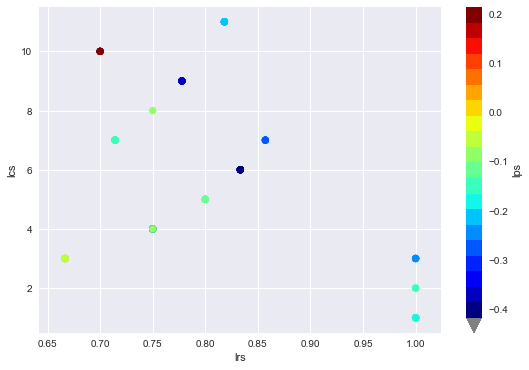

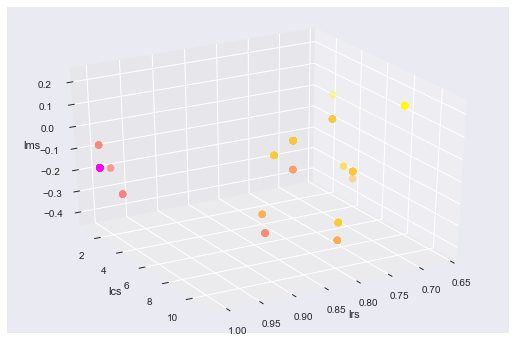

In [13]:
ump_deg.fit(p_ncs=slice(20, 40, 1), brust_min=False)

上面可视化结果各个轴分别代表：

* lcs: 分类簇中样本总数
* lrs: 分类簇中样本失败率
* lps: 分类簇中样本交易获利比例总和
* lms: 分类簇中样本每笔交易平均获利

ump_deg.cprs提取了使用gmm从20-40个分类中交易失败率大于65%的簇:

In [16]:
ump_deg.cprs.head()

,lcs,lms,lps,lrs
20_11,7,-0.0282,-0.1972,0.7143
20_19,1,-0.1797,-0.1797,1.0000
21_1,10,0.0216,0.2156,0.7000
21_13,9,-0.0423,-0.3809,0.7778
21_15,7,-0.0401,-0.2807,0.8571


对上表格第一行数据详细解释如下：

用gmm将特征进行分类，分20个类，这个分类中的第11簇失败率为0.6667，即index:20_11，这个分类中有7笔交易，平均每笔交易平均获利0.0282，分类中所有交易获利比例总和为-0.1972

备注：不同的运行环境下分类的结果序号等是不相同的

下面我们找出所有提取结果中交易失败概率最大的分类簇, 由于沙盒数据中数据量限制，导致每个分类簇中数据很少，下面的筛选条件是分类中有至少有5笔以上交易:

In [17]:
mfx = ump_deg.cprs[(ump_deg.cprs['lcs'] > 5)].sort_values(by='lrs')[::-1]
mfx.head()

,lcs,lms,lps,lrs
23_15,7,-0.0401,-0.2807,0.8571
21_15,7,-0.0401,-0.2807,0.8571
22_15,7,-0.0401,-0.2807,0.8571
24_15,7,-0.0401,-0.2807,0.8571
34_16,6,-0.0696,-0.4178,0.8333


从上面的输出可以看到23_15是失败概率很大的分类簇，接下来我们查看ump_deg.nts表，它是字典结构。

下面获得mfx分类簇下的所有交易的DataFrame数据对象, 寻找deg_ang252中存在非常大的数值的分类簇, 且分类簇中交易数量最多的GMM分类簇。

备注：不同的运行环境下分类的结果序号等是不相同的（GMM中初始随机数, 预热参数导致）, 即不同的环境下运行的结果不一定是23-15这个分类簇序号，但是分类的性质基本相似

In [21]:
max_failed_cluster_orders = None
for mfx_ind in np.arange(0, len(mfx)):
    tmp = ump_deg.nts[mfx.index[mfx_ind]]
    if tmp.buy_deg_ang252.mean() > 10:
        if max_failed_cluster_orders is None:
            max_failed_cluster_orders = tmp
        elif len(tmp) > len(max_failed_cluster_orders):
            # 寻找分类簇中交易数量最多的
            max_failed_cluster_orders = tmp

if max_failed_cluster_orders is None:
    max_failed_cluster_orders = ump_deg.nts[mfx.index[0]]
max_failed_cluster_orders

,result,buy_deg_ang42,buy_deg_ang252,buy_deg_ang60,buy_deg_ang21,ind,cluster
2015-02-18,1,7.544,21.959,2.577,0.429,53,15
2015-03-25,1,5.217,16.483,8.213,0.654,68,15
2015-04-10,0,8.559,23.632,2.437,6.003,77,15
2015-10-19,0,6.492,23.973,2.085,2.096,121,15
2015-10-20,0,8.226,18.983,-6.655,2.002,124,15
2015-10-20,0,15.407,14.483,3.308,3.866,125,15
2015-10-22,0,6.979,23.305,2.701,3.120,129,15
2015-10-26,0,7.901,19.609,-2.029,5.574,132,15
2015-10-27,0,14.644,14.923,4.431,3.581,138,15
2015-12-30,0,2.868,17.983,9.238,-0.160,152,15


下面分别统计分类簇和训练数据集中特征的平均值，可以看到：

- 分类簇中deg_ang252非常大，deg_ang42的值相比较训练集平均值也很大
- deg_ang21，deg_ang60平均值基本和训练集数据平均值持平

In [22]:
print('分类簇中deg_ang60平均值为{0:.2f}'.format(
    max_failed_cluster_orders.buy_deg_ang60.mean()))
print('训练数据集中deg_ang60平均值为{0:.2f}\n'.format(
    orders_pd_train.buy_deg_ang60.mean()))

print('分类簇中deg_ang21平均值为{0:.2f}'.format(
    max_failed_cluster_orders.buy_deg_ang21.mean()))
print('训练数据集中deg_ang21平均值为{0:.2f}\n'.format(
    orders_pd_train.buy_deg_ang21.mean()))


print('分类簇中deg_ang42平均值为{0:.2f}'.format(
    max_failed_cluster_orders.buy_deg_ang42.mean()))
print('训练数据集中deg_ang42平均值为{0:.2f}\n'.format(
    orders_pd_train.buy_deg_ang42.mean()))

print('分类簇中deg_ang252平均值为{0:.2f}'.format(
    max_failed_cluster_orders.buy_deg_ang252.mean()))
print('训练数据集中deg_ang252平均值为{0:.2f}'.format(
    orders_pd_train.buy_deg_ang252.mean()))

分类簇中deg_ang60平均值为2.68
训练数据集中deg_ang60平均值为1.56

分类簇中deg_ang21平均值为2.54
训练数据集中deg_ang21平均值为4.87

分类簇中deg_ang42平均值为8.04
训练数据集中deg_ang42平均值为4.48

分类簇中deg_ang252平均值为19.43
训练数据集中deg_ang252平均值为3.25


更进一步，我们将所有分类簇中的交易快照进行可视化，进行人工分析，如下代码所示：

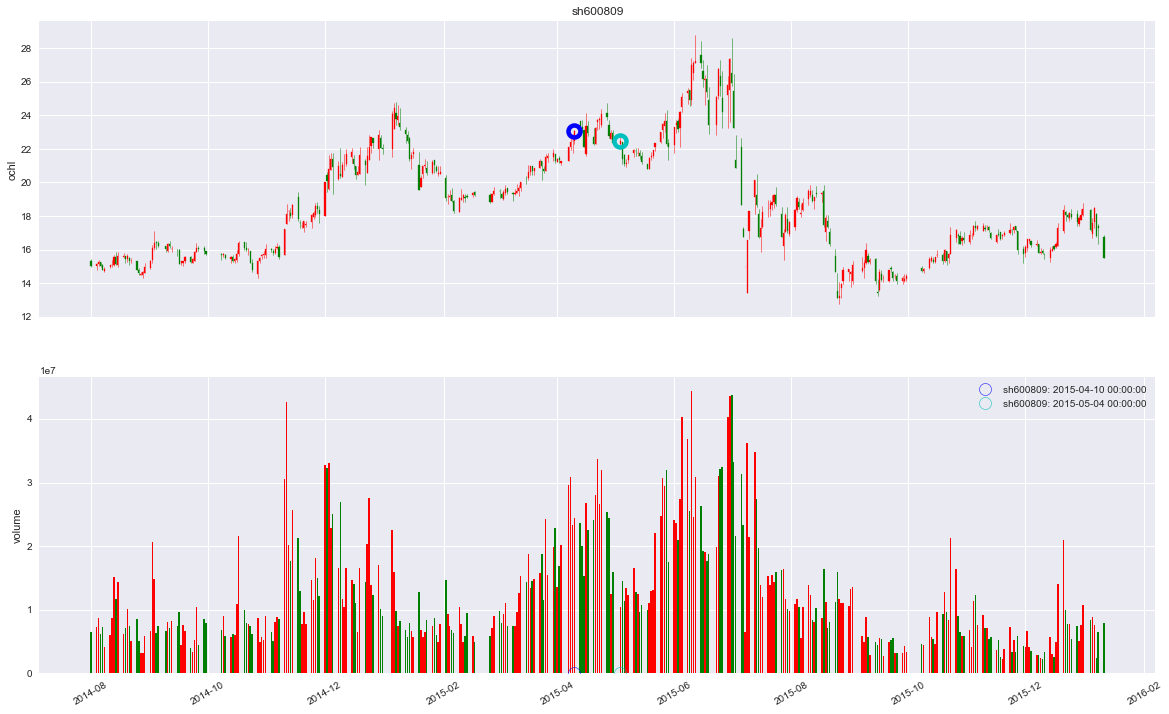

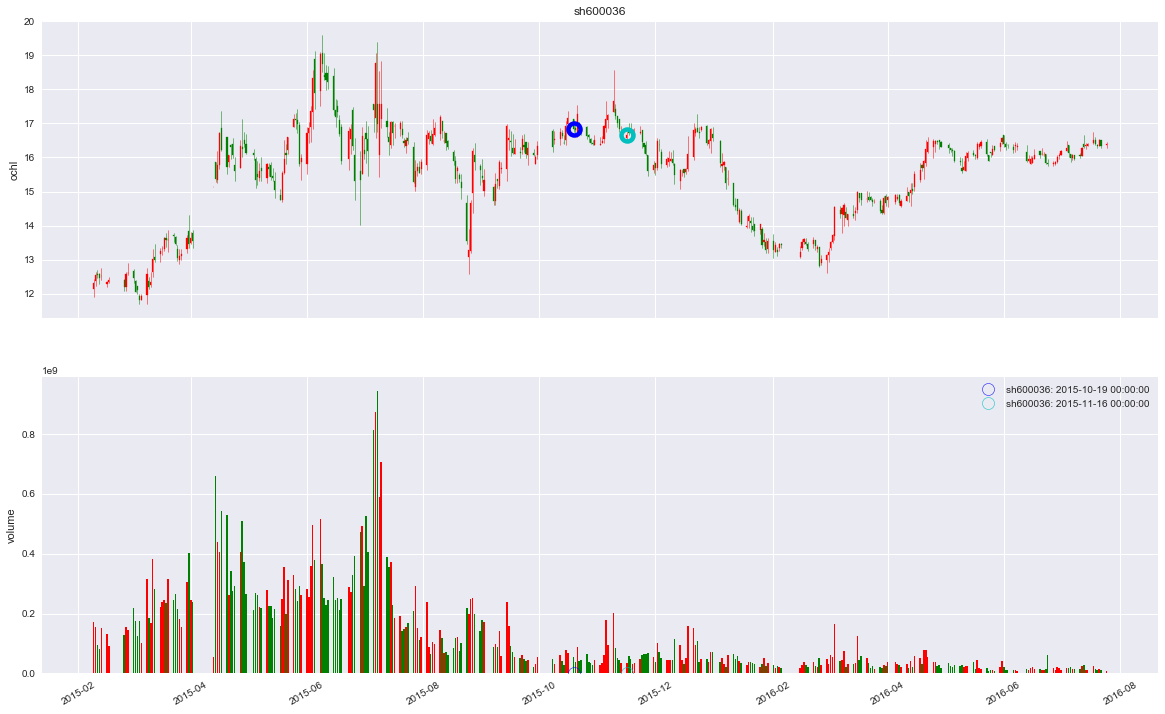

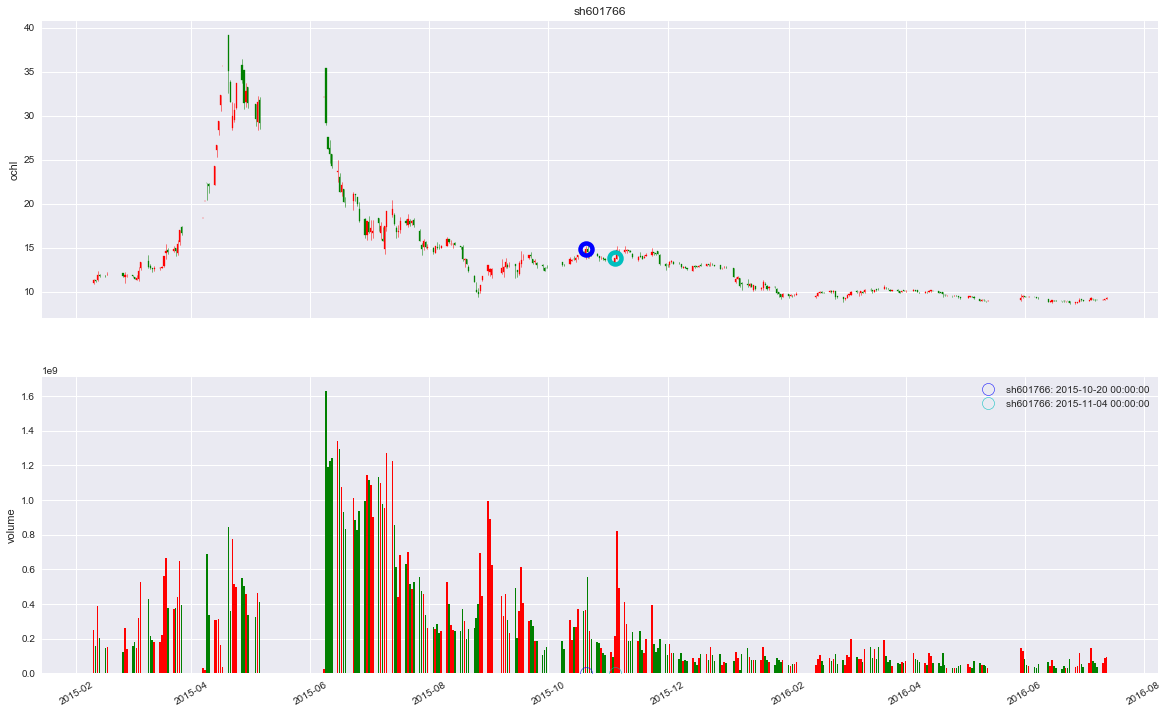

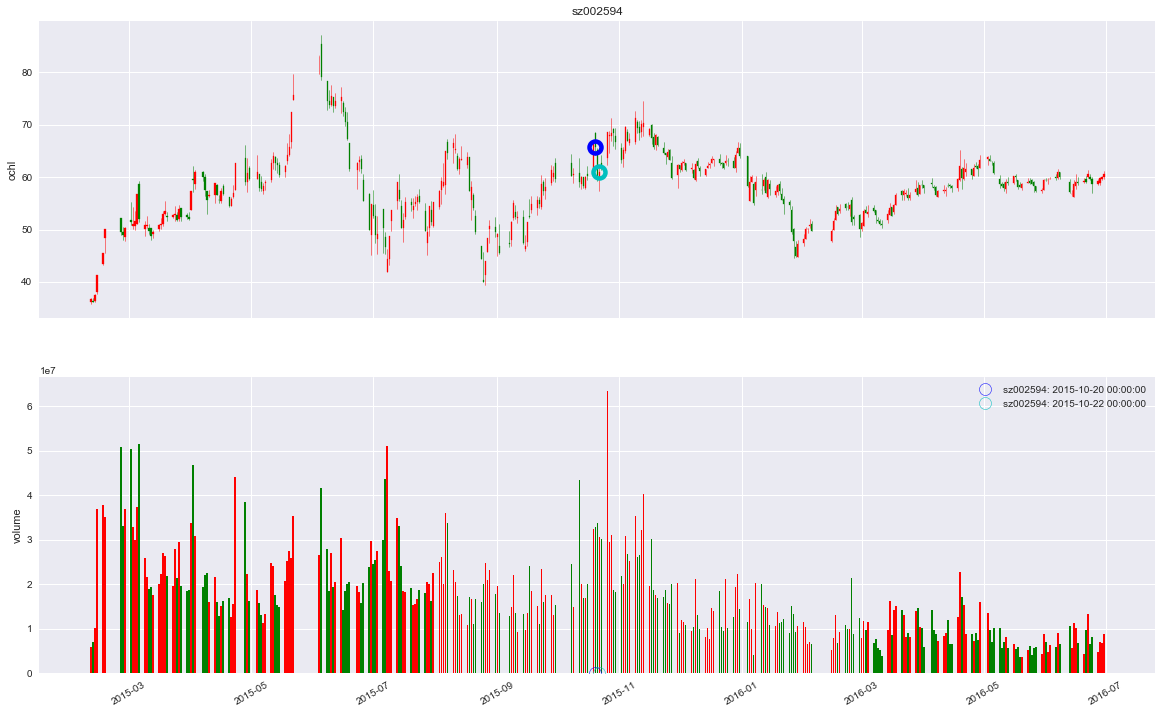

In [23]:
cp = []
for ind in np.arange(0, len(max_failed_cluster_orders)):
    # 获取其在原始orders中的ind
    order_ind = int(max_failed_cluster_orders.iloc[ind].ind)
    # 从原始orders中取出order
    order = ump_deg.fiter.order_has_ret.iloc[order_ind]
    if order.symbol.isdigit() and order.symbol not in cp:
        # 介于篇幅长度，只可视化a股市场的了，每个symbol只绘制一次，避免42d和60d策略同时生效，两个单子，这里绘制两次
        cp.append(order.symbol)
        ABuMarketDrawing.plot_candle_from_order(order, date_ext=252)

### 5. 赋予宏观上合理的解释：

上面显示的交易sh600809是本节初失败结果人工分析的那个案例的交易，这里它在主裁deg识别中被捕获。这样我们就不需要在具体策略中编写代码阻止类似的交易生效，它被机器学习gmm识别到一个固定的分类簇中，我们保存这个分类簇，在之后的交易可以运用这个分类簇对新的交易进行裁判。

从上面的走势快照以及特征值分析可以对gmm这次分类进行宏观上合理的解释：

* 过去一年的股价走势快速拉升（deg_ang252非常大）
* 过去3三个月走势失去了前期的气势，开始走下坡路（deg_ang60平均值持平与训练集数据平均值）
* 过去2个月走势有一次回光反照(deg_ang42的值相比较训练集平均值也很大)

**最终拦截的交易宏观上的解释为：快速拉升后的震荡下行走势下的小上升走势，且遇到了短期阻力位(由上面交易图可见)**


上面的分析即做到了机器学习技术在搜索引擎（量化策略）的改进，必须赋予宏观上合理的解释。


你可以发现如果你想要手工在策略中通过编写代码添加这个规则时，逻辑代码的实现会相当复杂，而且不得不面对阀值问题，使用gmm分类簇可以有效规避此类问题，而且使得代码逻辑清晰，没有过多的硬编码，且在之后的交易中指导策略进行信号拦截

### 6. 最优分类簇筛选：

上面我们抽取了gmm大于阀值失败率的分类簇后，对ump_deg.cprs进行分析可以发现:

在很多分类簇中的交易胜率不高，但是交易获利比例总和却为正值, 即有很多交易簇，虽然簇的失败率很高，但是簇中所有交易的收益和却是正值，即一直强调的不能只关注胜率，盈亏比更是关键。

那么我们将所有分类簇保存在本地，对之后的交易进行裁决显然是不妥当的。

In [28]:
ump_deg.cprs[ump_deg.cprs['lps'] > 0].head()

,lcs,lms,lps,lrs
21_1,10,0.0216,0.2156,0.7
22_1,10,0.0216,0.2156,0.7
23_1,10,0.0216,0.2156,0.7
24_1,10,0.0216,0.2156,0.7
25_1,10,0.0216,0.2156,0.7



下面我们使用全局最优技术对分类簇集合进行筛选, 如下所示:

备注：

- 对外的使用实际不会涉及如下内容，如在之后的章节中主裁的训练只使用一行代码即可完成，这里不必过分深入
- 如对内部实现敢兴趣，请阅读《量化交易之路》中相关内容或者阅读源代码。

In [22]:
brust_min = ump_deg.brust_min()
brust_min

array([-0.098, -0.018,  0.667])

下面根据上面计算出的最优参数对分类簇集合进行筛选。

* 分类簇中样本交易获利比例总和小于-0.1
* 分类簇中样本每笔交易平均获利小于-0.01
* 分类簇中样本失败率大于0.67

如下代码返回的llps为最终筛选结果, 将筛选后的结果使用dump_clf接口进行保存（最终角度主裁模型）保存在本地，以预备之后对新的交易进行裁决。

In [23]:
llps = ump_deg.cprs[(ump_deg.cprs['lps'] <= brust_min[0]) & (ump_deg.cprs['lms'] <= brust_min[1]) & 
                    (ump_deg.cprs['lrs'] >= brust_min[2])]
ump_deg.dump_clf(llps)

please wait! dump_pickle....: /Users/Bailey/abu/data/ump/ump_main_us_deg_main


小结：

本节演示了使用abupy对回测结果进行的人工分析，分步讲解ump裁判拦截的大体实现思路，训练了角度主裁，下一节将完成其它主裁的训练，但是会使用一行代码完成，不会像本节示例如此繁琐。

#### abu量化文档目录章节

1. [择时策略的开发](http://www.abuquant.com/lecture/lecture_1.html)
2. [择时策略的优化](http://www.abuquant.com/lecture/lecture_2.html)
3. [滑点策略与交易手续费](http://www.abuquant.com/lecture/lecture_3.html)
4. [多支股票择时回测与仓位管理](http://www.abuquant.com/lecture/lecture_4.html)
5. [选股策略的开发](http://www.abuquant.com/lecture/lecture_5.html)
6. [回测结果的度量](http://www.abuquant.com/lecture/lecture_6.html)
7. [寻找策略最优参数和评分](http://www.abuquant.com/lecture/lecture_7.html)
8. [A股市场的回测](http://www.abuquant.com/lecture/lecture_8.html)
9. [港股市场的回测](http://www.abuquant.com/lecture/lecture_9.html)
10. [比特币，莱特币的回测](http://www.abuquant.com/lecture/lecture_10.html)
11. [期货市场的回测](http://www.abuquant.com/lecture/lecture_11.html)
12. [机器学习与比特币示例](http://www.abuquant.com/lecture/lecture_12.html)
13. [量化技术分析应用](http://www.abuquant.com/lecture/lecture_13.html)
14. [量化相关性分析应用](http://www.abuquant.com/lecture/lecture_14.html)
15. [量化交易和搜索引擎](http://www.abuquant.com/lecture/lecture_15.html)
16. [UMP主裁交易决策](http://www.abuquant.com/lecture/lecture_16.html)
17. [UMP边裁交易决策](http://www.abuquant.com/lecture/lecture_17.html)
18. [自定义裁判决策交易](http://www.abuquant.com/lecture/lecture_18.html)
19. [数据源](http://www.abuquant.com/lecture/lecture_19.html)
20. [A股全市场回测](http://www.abuquant.com/lecture/lecture_20.html)
21. [A股UMP决策](http://www.abuquant.com/lecture/lecture_21.html)
22. [美股全市场回测](http://www.abuquant.com/lecture/lecture_22.html)
23. [美股UMP决策](http://www.abuquant.com/lecture/lecture_23.html)

abu量化系统文档教程持续更新中，请关注公众号中的更新提醒。

#### 《量化交易之路》目录章节及随书代码地址

1. [第二章 量化语言——Python](https://github.com/bbfamily/abu/tree/master/ipython/第二章-量化语言——Python.ipynb)
2. [第三章 量化工具——NumPy](https://github.com/bbfamily/abu/tree/master/ipython/第三章-量化工具——NumPy.ipynb)
3. [第四章 量化工具——pandas](https://github.com/bbfamily/abu/tree/master/ipython/第四章-量化工具——pandas.ipynb)
4. [第五章 量化工具——可视化](https://github.com/bbfamily/abu/tree/master/ipython/第五章-量化工具——可视化.ipynb)
5. [第六章 量化工具——数学：你一生的追求到底能带来多少幸福](https://github.com/bbfamily/abu/tree/master/ipython/第六章-量化工具——数学.ipynb)
6. [第七章 量化系统——入门：三只小猪股票投资的故事](https://github.com/bbfamily/abu/tree/master/ipython/第七章-量化系统——入门.ipynb)
7. [第八章 量化系统——开发](https://github.com/bbfamily/abu/tree/master/ipython/第八章-量化系统——开发.ipynb)
8. [第九章 量化系统——度量与优化](https://github.com/bbfamily/abu/tree/master/ipython/第九章-量化系统——度量与优化.ipynb)
9. [第十章 量化系统——机器学习•猪老三](https://github.com/bbfamily/abu/tree/master/ipython/第十章-量化系统——机器学习•猪老三.ipynb)
10. [第十一章 量化系统——机器学习•ABU](https://github.com/bbfamily/abu/tree/master/ipython/第十一章-量化系统——机器学习•ABU.ipynb)
11. [附录A 量化环境部署](https://github.com/bbfamily/abu/tree/master/ipython/附录A-量化环境部署.ipynb)
12. [附录B 量化相关性分析](https://github.com/bbfamily/abu/tree/master/ipython/附录B-量化相关性分析.ipynb)
13. [附录C 量化统计分析及指标应用](https://github.com/bbfamily/abu/tree/master/ipython/附录C-量化统计分析及指标应用.ipynb)

[更多阿布量化量化技术文章](http://www.abuquant.com/article)


更多关于量化交易相关请阅读[《量化交易之路》](http://www.abuquant.com/books/quantify-trading-road.html)

更多关于量化交易与机器学习相关请阅读[《机器学习之路》](http://www.abuquant.com/books/machine-learning-road.html)

更多关于abu量化系统请关注微信公众号: abu_quant

![](./image/qrcode.jpg)